In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    average_precision_score,
    precision_recall_fscore_support,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [ ]:
excel_file_path = '/content/medicine_store_data_Final.xlsx'  # 2 minutees

df = pd.read_excel(excel_file_path, sheet_name='Purchases')

In [ ]:
print(df.head(5))

   purchase_id  user_id            user_name                       user_email  \
0            1     3776        Nabanita Basu      3794nabanitabasu@icloud.com   
1            2    13185     Pritha Chowdhury   prit1968hachowdhury@icloud.com   
2            3     2009     Jayanti Banerjee    4174jayantibanerjee@yahoo.com   
3            4    12918      Sohom Chowdhury     sohomchowdhury6270@yahoo.com   
4            5     1644  Tilottama Mukherjee  714tilottamamukherjee@yahoo.com   

      locality  age  gender               medicine_name  salt_composition  \
0     Agarpara   32  Female        Oesocid-L Capsule PR               NaN   
1      Sodepur   27  Female  Tolkem-D 150mg/50mg Tablet               NaN   
2  Barrackpore   53  Female       Rytab 2.5mg Tablet MD               NaN   
3      Sodepur   46    Male       Olimelt 2.5 Tablet MD               NaN   
4  Barrackpore   29  Female           Nicip Plus Tablet               NaN   

                manufacturer  uses  \
0   AAR ESS 

90 days no purchase

In [ ]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# 2. Define churn (90-day inactivity)
def assign_churn(df):
    # Find most recent purchase date for each user
    last_purchase = df.groupby('user_id')['purchase_date'].max().reset_index()

    # Calculate cutoff (90 days before last date in dataset)
    cutoff_date = df['purchase_date'].max() - timedelta(days=90)

    # Mark churners
    last_purchase['churn'] = (last_purchase['purchase_date'] < cutoff_date).astype(int)

    # Merge back with original data
    if 'churn' in df.columns:
        df = df.drop(columns=['churn'])
    df = df.merge(last_purchase[['user_id', 'churn']], on='user_id', how='left')

    # Users with no purchases = churned
    df['churn'] = df['churn'].fillna(1)
    return df

df = assign_churn(df)

# 3. Create user-level features
def create_user_features(df):
    features = df.groupby('user_id').agg({
        'quantity': 'sum',
        'total_price': 'sum',
        'purchase_date': 'count',
        'age': 'first',
        'gender': 'first',
        'locality': 'first',
        'payment_method': lambda x: x.mode()[0],
        'rating': 'mean'
    }).reset_index()

    features.rename(columns={
        'purchase_date': 'num_purchases',
        'quantity': 'total_quantity',
        'total_price': 'total_spent',
        'rating': 'avg_rating'
    }, inplace=True)

    # Merge churn status
    features = features.merge(
        df[['user_id', 'churn']].drop_duplicates(),
        on='user_id',
        how='left'
    )
    return features

user_features = create_user_features(df)

# 5. Train-test split
X = user_features.drop(columns=['user_id', 'churn'])
y = user_features['churn'].astype(int)

# Verification
print("Churn rate (90-day inactivity):", f"{y.mean():.1%}")
print("\nSample features:")
print(user_features[['user_id', 'churn', 'total_spent', 'num_purchases']].head(3))

Churn rate (90-day inactivity): 5.5%

Sample features:
   user_id  churn  total_spent  num_purchases
0        1      0     22684.92             28
1        2      0      9734.48             19
2        3      0     11994.47             13


In [ ]:
X

,total_quantity,total_spent,num_purchases,age,gender,locality,payment_method,avg_rating
0,49,22684.92,28,19,Female,Agarpara,Credit Card,3.095238
1,25,9734.48,19,39,Female,Khardah,Credit Card,3.000000
2,20,11994.47,13,52,Male,Agarpara,Cash,3.000000
3,35,15486.11,21,32,Male,Agarpara,Cash,3.222222
4,12,6058.85,7,26,Female,Khardah,Debit Card,3.000000
...,...,...,...,...,...,...,...,...
18620,57,31531.73,36,47,Female,Barrackpore,UPI,3.206897
18621,12,5817.62,7,44,Male,Sodepur,Cash,2.666667
18622,23,8977.41,14,44,Male,Agarpara,UPI,2.300000
18623,16,7737.10,12,43,Male,Sodepur,UPI,3.000000


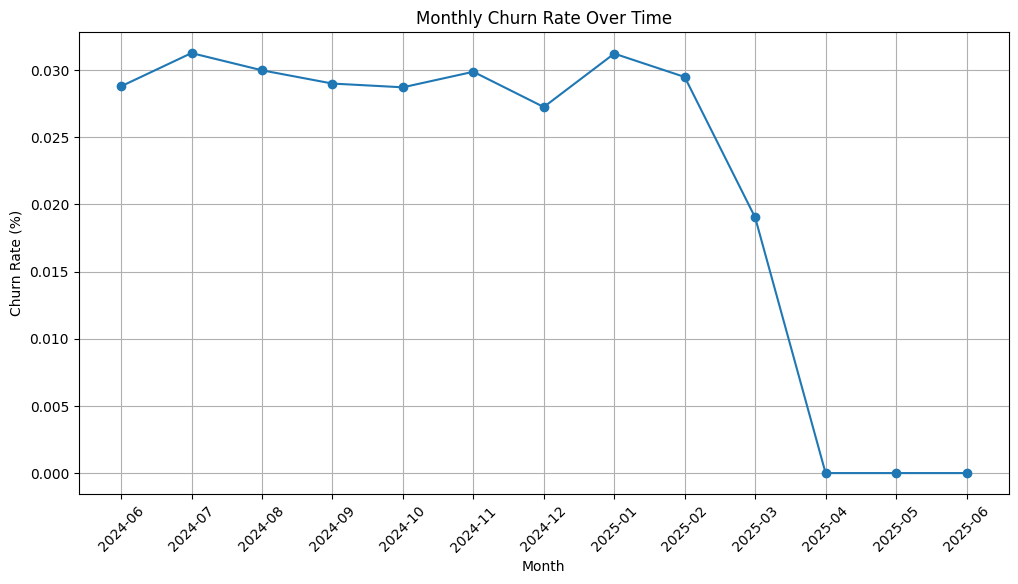

In [ ]:
# Extract month and year from purchase_date
df['purchase_month'] = df['purchase_date'].dt.to_period('M')  # e.g., "2024-01"

# Group by month and calculate churn rate
monthly_churn = df.groupby('purchase_month')['churn'].mean().reset_index()
monthly_churn.columns = ['Month', 'Churn_Rate']

# Plot monthly churn trends
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(monthly_churn['Month'].astype(str), monthly_churn['Churn_Rate'], marker='o')
plt.title("Monthly Churn Rate Over Time")
plt.xlabel("Month")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

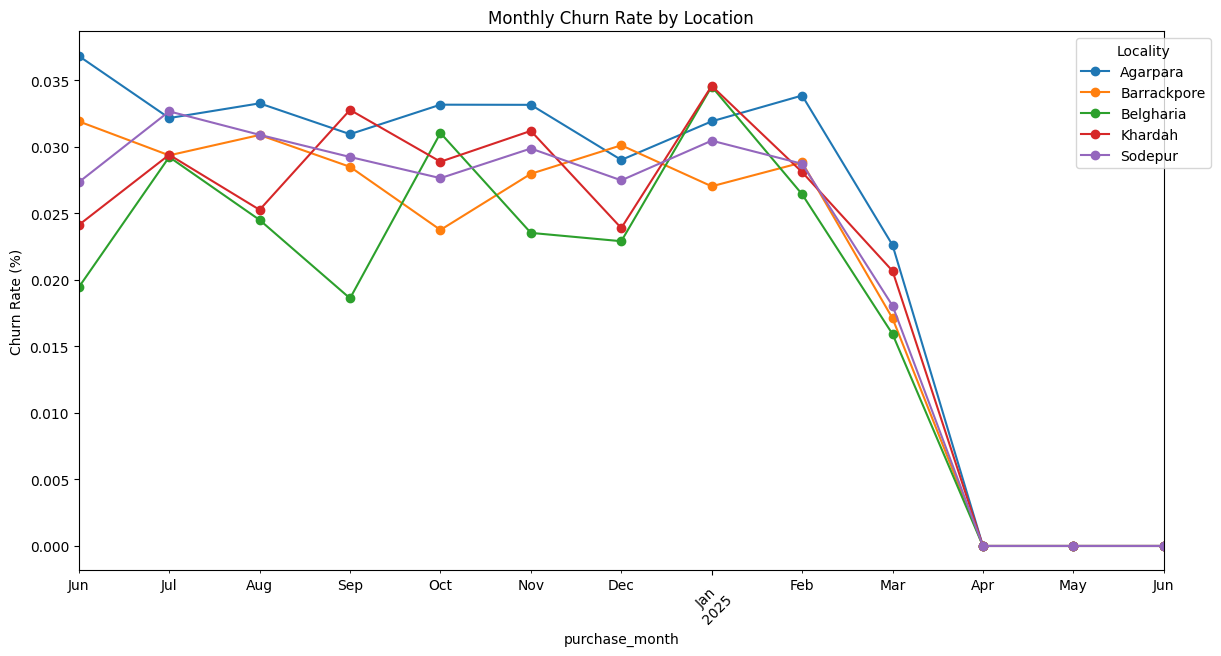

In [ ]:
location_monthly_churn = df.groupby(['purchase_month', 'locality'])['churn'].mean().unstack()
location_monthly_churn.plot(kind='line', figsize=(14, 7), marker='o')
plt.title("Monthly Churn Rate by Location")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45)
plt.legend(title='Locality', bbox_to_anchor=(1.05, 1))
plt.show()

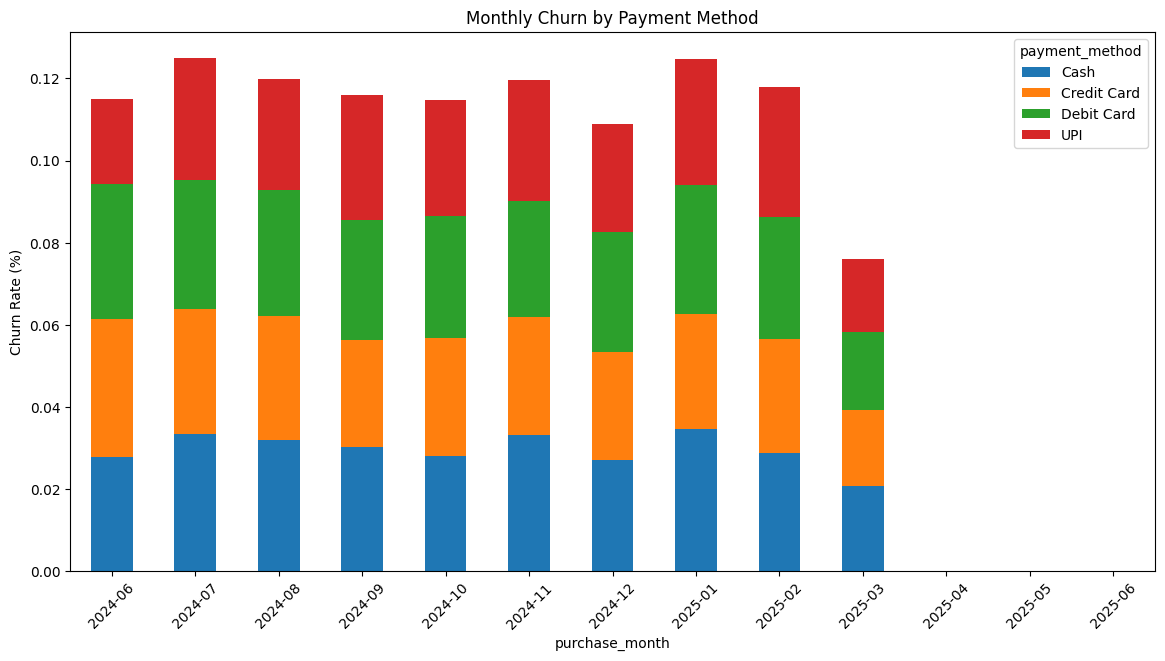

In [ ]:
payment_monthly_churn = df.groupby(['purchase_month', 'payment_method'])['churn'].mean().unstack()
payment_monthly_churn.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title("Monthly Churn by Payment Method")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# # (Assuming 'medicine_category' exists, else group by manufacturer)
# product_monthly_churn = df.groupby(['purchase_month', 'manufacturer'])['churn'].mean().unstack()
# product_monthly_churn.plot(kind='line', figsize=(16, 8), marker='o')
# plt.title("Monthly Churn by Manufacturer")
# plt.ylabel("Churn Rate (%)")
# plt.xticks(rotation=45)
# plt.legend(title='Manufacturer', bbox_to_anchor=(1.05, 1))
# plt.show()

Logistic


Logistic Regression Performance

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.751     0.854      3520
           1      0.168     0.863     0.282       205

    accuracy                          0.758      3725
   macro avg      0.579     0.807     0.568      3725
weighted avg      0.944     0.758     0.823      3725


Average Precision Score: 0.401

Confusion Matrix:
[[2645  875]
 [  28  177]]

Top 10 Most Predictive Features:
                   Feature  Coefficient  Odds_Ratio
             num_purchases    -3.076559    0.046118
payment_method_Credit Card    -0.266871    0.765772
        locality_Belgharia    -0.222843    0.800241
        payment_method_UPI    -0.134278    0.874347
               total_spent    -0.132987    0.875477
            total_quantity     0.110476    1.116810
         locality_Agarpara     0.095654    1.100378
       payment_method_Cash     0.057107    1.058769
               gender_Male     0.0300

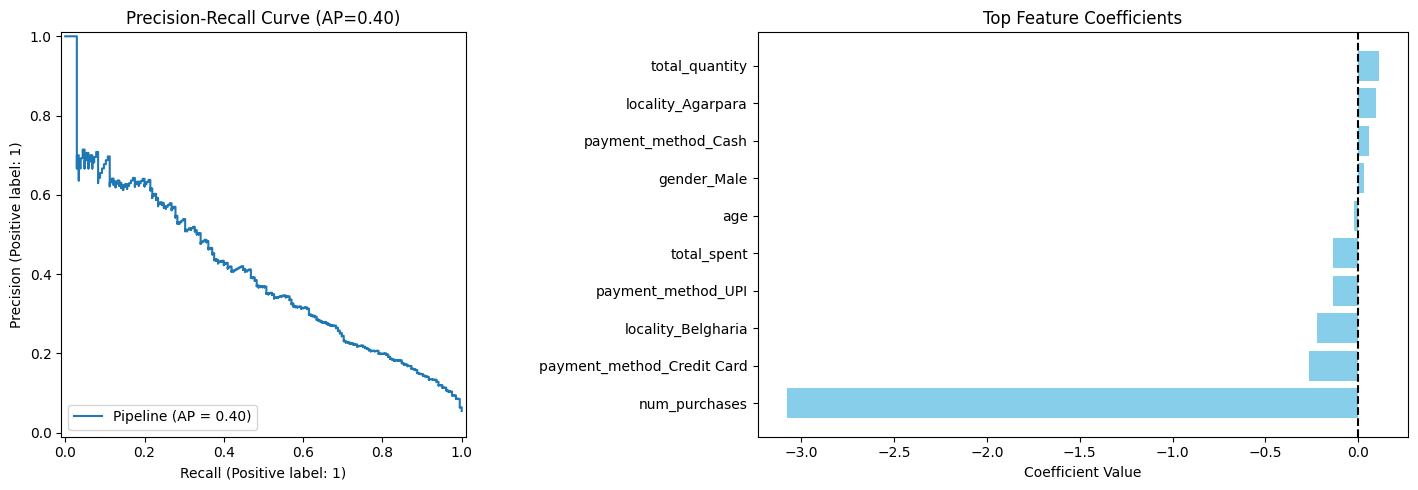

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Feature Definitions (update with your actual columns)
numeric_features = ['age', 'total_quantity', 'total_spent', 'num_purchases', 'avg_rating']
categorical_features = ['gender', 'locality', 'payment_method']

# 2. Enhanced Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore',
                                    sparse_output=False,
                                    drop='if_binary'))  # Optimize binary features
        ]), categorical_features)
    ],
    remainder='drop'  # Explicitly drop unused columns
)

# 3. Logistic Regression with Balanced Class Weight
logreg_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='liblinear',
        penalty='l1'  # Added L1 regularization for feature selection
    ))
])

# 4. Train-Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5. Train and Evaluate
logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)
y_probs = logreg_pipeline.predict_proba(X_test)[:, 1]

# 6. Enhanced Evaluation Metrics
print("="*80)
print("Logistic Regression Performance")
print("="*80)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Average Precision
ap_score = average_precision_score(y_test, y_probs)
print(f"\nAverage Precision Score: {ap_score:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 7. Feature Importance with Interpretation
cat_feature_names = (
    logreg_pipeline.named_steps['preprocessing']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical_features)
)

all_features = numeric_features + list(cat_feature_names)

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': logreg_pipeline.named_steps['classifier'].coef_[0],
    'Odds_Ratio': np.exp(logreg_pipeline.named_steps['classifier'].coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Predictive Features:")
print(feature_importance.head(10).to_string(index=False))

# 8. Visualizations
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(logreg_pipeline, X_test, y_test, ax=ax[0])
ax[0].set_title(f'Precision-Recall Curve (AP={ap_score:.2f})')

# Top Feature Coefficients
top_features = feature_importance.head(10).sort_values('Coefficient')
ax[1].barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
ax[1].axvline(0, color='k', linestyle='--')
ax[1].set_title('Top Feature Coefficients')
ax[1].set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

# 9. Model Persistence
logreg_model = logreg_pipeline

In [ ]:
# After fitting the model, print the mapping:
encoder = logreg_pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['encoder']
print("Payment Method Categories:", encoder.categories_[2])  # Assuming payment_method is 3rd in categorical_features

Payment Method Categories: ['Cash' 'Credit Card' 'Debit Card' 'UPI']


In [ ]:
# Get the OneHotEncoder from the pipeline
preprocessor = logreg_pipeline.named_steps['preprocessing']
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']

# Print the mapping for categorical features
for i, feature in enumerate(categorical_features):
    print(f"\nCategories for '{feature}':")
    print(cat_encoder.categories_[i])


Categories for 'gender':
['Female' 'Male']

Categories for 'locality':
['Agarpara' 'Barrackpore' 'Belgharia' 'Khardah' 'Sodepur']

Categories for 'payment_method':
['Cash' 'Credit Card' 'Debit Card' 'UPI']


In [ ]:
# After fitting the pipeline, add this:
print("\n===== CATEGORY MAPPING =====")
for i, feature in enumerate(categorical_features):
    categories = cat_encoder.categories_[i]
    print(f"\n{feature}:")
    for j, cat in enumerate(categories):
        print(f"  {feature}_{j} → {cat}")


===== CATEGORY MAPPING =====

gender:
  gender_0 → Female
  gender_1 → Male

locality:
  locality_0 → Agarpara
  locality_1 → Barrackpore
  locality_2 → Belgharia
  locality_3 → Khardah
  locality_4 → Sodepur

payment_method:
  payment_method_0 → Cash
  payment_method_1 → Credit Card
  payment_method_2 → Debit Card
  payment_method_3 → UPI


In [ ]:
# Get feature names after preprocessing
numeric_features_transformed = logreg_pipeline.named_steps['preprocessing'].named_transformers_['num'].get_feature_names_out(numeric_features)
categorical_features_transformed = logreg_pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
all_features = list(numeric_features_transformed) + list(categorical_features_transformed)

# Get coefficients
if hasattr(logreg_pipeline.named_steps['classifier'], 'coef_'):
    coefficients = logreg_pipeline.named_steps['classifier'].coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients
    })
    feature_importance['Absolute_Value'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values('Absolute_Value', ascending=False)
    print("Logistic Regression Feature Importance:")
    print(feature_importance.head(20))
elif hasattr(logreg_pipeline.named_steps['classifier'], 'feature_importances_'):
    importances = logreg_pipeline.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    print("Tree-based Feature Importance:")
    print(feature_importance.head(20))
else:
    print("Classifier doesn't support coef_ or feature_importances_")

Logistic Regression Feature Importance:
                       Feature  Coefficient  Absolute_Value
3                num_purchases    -3.076559        3.076559
12  payment_method_Credit Card    -0.266871        0.266871
8           locality_Belgharia    -0.222843        0.222843
14          payment_method_UPI    -0.134278        0.134278
2                  total_spent    -0.132987        0.132987
1               total_quantity     0.110476        0.110476
6            locality_Agarpara     0.095654        0.095654
11         payment_method_Cash     0.057107        0.057107
5                  gender_Male     0.030043        0.030043
0                          age    -0.022505        0.022505
7         locality_Barrackpore    -0.015023        0.015023
9             locality_Khardah    -0.014848        0.014848
4                   avg_rating    -0.009180        0.009180
10            locality_Sodepur     0.000000        0.000000
13   payment_method_Debit Card     0.000000        0.000000


In [ ]:
X.head(5)

,total_quantity,total_spent,num_purchases,age,gender,locality,payment_method,avg_rating
0,49,22684.92,28,19,Female,Agarpara,Credit Card,3.095238
1,25,9734.48,19,39,Female,Khardah,Credit Card,3.000000
2,20,11994.47,13,52,Male,Agarpara,Cash,3.000000
3,35,15486.11,21,32,Male,Agarpara,Cash,3.222222
4,12,6058.85,7,26,Female,Khardah,Debit Card,3.000000


Forecast

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Convert to time-series data
monthly_churn_ts = monthly_churn.set_index('Month')['Churn_Rate']

# Fit ARIMA model (adjust order as needed)
model = ARIMA(monthly_churn_ts, order=(1, 1, 1))
model_fit = model.fit()

# Forecast next 3 months
forecast = model_fit.forecast(steps=3)
print("Next 3 Months Churn Forecast:\n", forecast)

Next 3 Months Churn Forecast:
 2025-07   -0.001301
2025-08   -0.001364
2025-09   -0.001367
Freq: M, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Random Forest

Random Forest Performance

Classification Report:
              precision    recall  f1-score   support

           0      0.975     0.885     0.928      3520
           1      0.236     0.610     0.340       205

    accuracy                          0.870      3725
   macro avg      0.605     0.747     0.634      3725
weighted avg      0.934     0.870     0.895      3725


Average Precision Score: 0.294

Confusion Matrix:
[[3115  405]
 [  80  125]]

Top 10 Most Predictive Features:
                   Feature  Importance  Normalized_Importance
             num_purchases    0.324958               1.000000
            total_quantity    0.242428               0.746030
               total_spent    0.221610               0.681966
                avg_rating    0.077892               0.239698
                       age    0.061720               0.189932
               gender_Male    0.010790               0.033205
          locality_Sodepur    0.007947               0.024457
       payment_

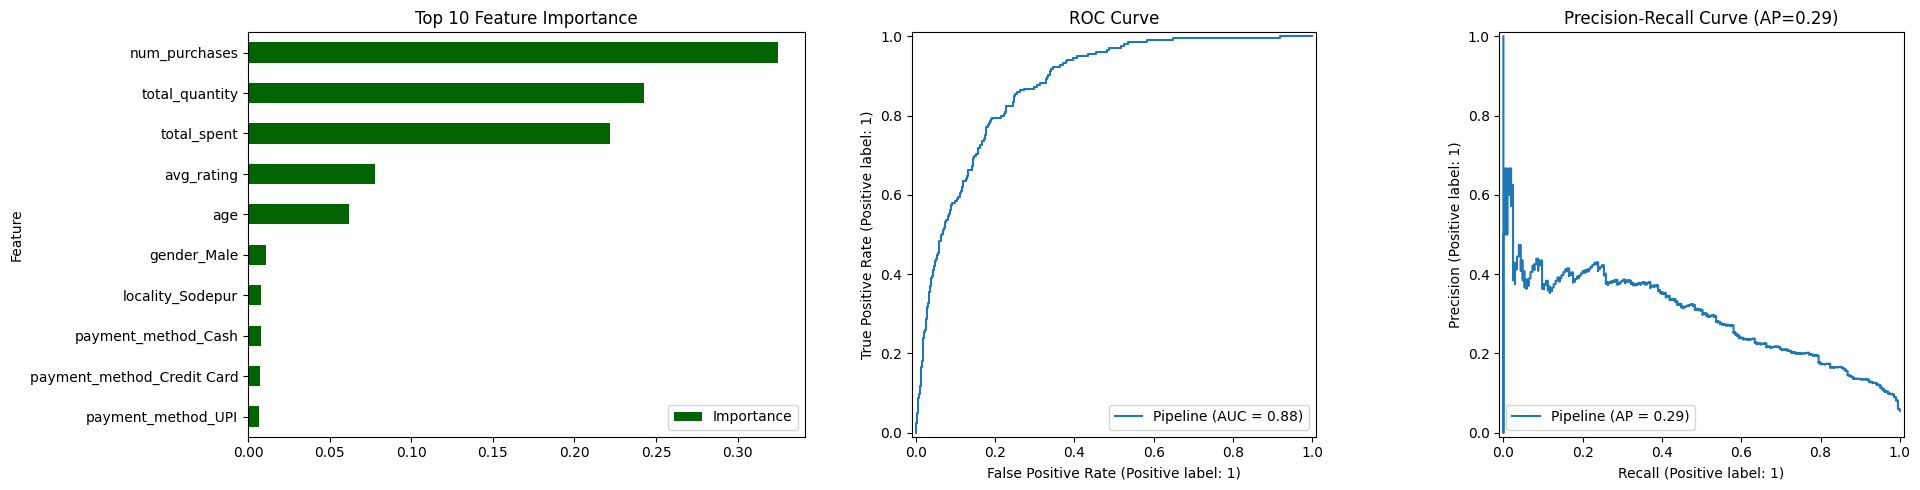

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# 1. Define feature types (update with your actual columns)
numeric_features = ['age', 'total_quantity', 'total_spent', 'num_purchases', 'avg_rating']
categorical_features = ['gender', 'locality', 'payment_method']

# 2. Preprocessing Pipeline (same as before for consistency)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore',
                                    sparse_output=False,
                                    drop='if_binary'))
        ]), categorical_features)
    ],
    remainder='drop'
)

# 3. Random Forest Pipeline with Balanced Class Weight
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,          # Increased for better stability
        max_depth=10,               # Prevent overfitting
        class_weight='balanced',
        random_state=42,
        n_jobs=-1                  # Use all CPU cores
    ))
])

# 4. Train and Evaluate
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
y_probs = rf_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (churn)

# 5. Comprehensive Evaluation
print("="*80)
print("Random Forest Performance")
print("="*80)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Average Precision
ap_score = average_precision_score(y_test, y_probs)
print(f"\nAverage Precision Score: {ap_score:.3f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6. Feature Importance with Interpretation
# 6. Feature Importance with Interpretation (Corrected)
cat_feature_names = (
    rf_pipeline.named_steps['preprocessing']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(input_features=categorical_features)  # Pass original column names
)

all_features = numeric_features + list(cat_feature_names)  # Now includes full names like "payment_method_UPI"

rf_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_pipeline.named_steps['classifier'].feature_importances_,
    'Normalized_Importance': rf_pipeline.named_steps['classifier'].feature_importances_ /
                           rf_pipeline.named_steps['classifier'].feature_importances_.max()
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Predictive Features:")
print(rf_importance.head(10).to_string(index=False))

# 7. Enhanced Visualizations
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Feature Importance
rf_importance.head(10).sort_values('Importance').plot.barh(
    x='Feature', y='Importance', ax=ax[0], color='darkgreen')
ax[0].set_title('Top 10 Feature Importance')

# ROC Curve
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test, ax=ax[1])
ax[1].set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(rf_pipeline, X_test, y_test, ax=ax[2])
ax[2].set_title(f'Precision-Recall Curve (AP={ap_score:.2f})')

plt.tight_layout()
plt.show()

# 8. Model Persistence
rf_model = rf_pipeline

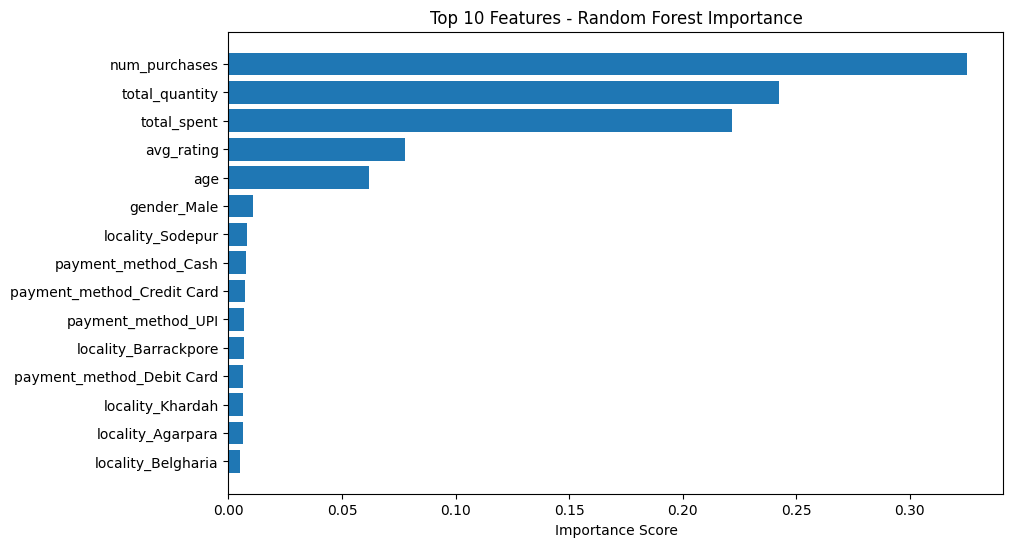

Top 10 Features Affecting Churn:
                       Feature  Importance  Normalized_Importance
3                num_purchases    0.324958               1.000000
1               total_quantity    0.242428               0.746030
2                  total_spent    0.221610               0.681966
4                   avg_rating    0.077892               0.239698
0                          age    0.061720               0.189932
5                  gender_Male    0.010790               0.033205
10            locality_Sodepur    0.007947               0.024457
11         payment_method_Cash    0.007851               0.024161
12  payment_method_Credit Card    0.007267               0.022362
14          payment_method_UPI    0.006724               0.020693
7         locality_Barrackpore    0.006627               0.020394
13   payment_method_Debit Card    0.006436               0.019805
9             locality_Khardah    0.006363               0.019581
6            locality_Agarpara    0.006205 

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'][:16], rf_importance['Importance'][:16])
plt.title('Top 10 Features - Random Forest Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

print("Top 10 Features Affecting Churn:")
print(rf_importance.head(16))

XGBoost

XGBoost Performance

Classification Report:
              precision    recall  f1-score   support

           0      0.962     0.965     0.964      3520
           1      0.369     0.351     0.360       205

    accuracy                          0.931      3725
   macro avg      0.666     0.658     0.662      3725
weighted avg      0.930     0.931     0.930      3725


Average Precision Score: 0.305

Confusion Matrix:
[[3397  123]
 [ 133   72]]

Top 10 Most Predictive Features (Gain):
                   Feature     Gain  Rank
             num_purchases 0.269212     1
            total_quantity 0.091426     2
               total_spent 0.061380     3
                       age 0.053202     4
payment_method_Credit Card 0.052012     5
                avg_rating 0.051978     6
          locality_Sodepur 0.051397     7
      locality_Barrackpore 0.051012     8
        payment_method_UPI 0.049790     9
         locality_Agarpara 0.047326    10


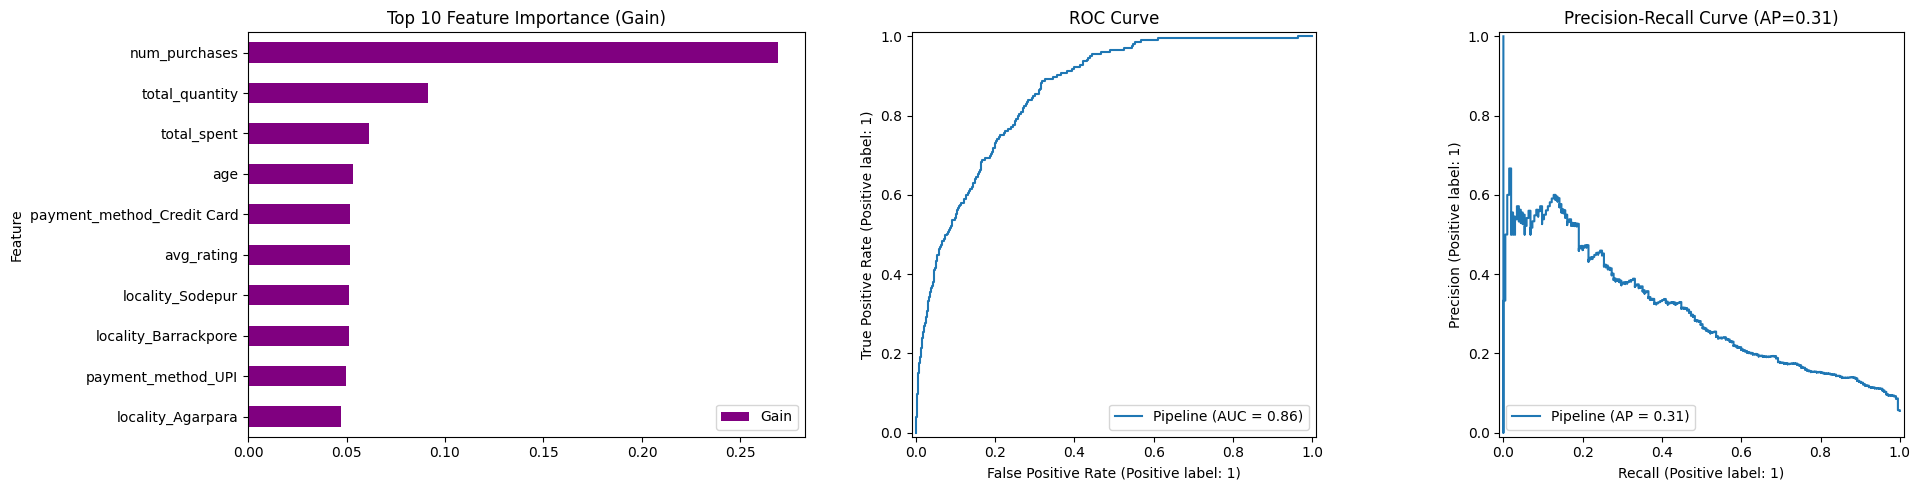

In [ ]:
import xgboost as xgb

# 1. Define feature types (update with your actual columns)
numeric_features = ['age', 'total_quantity', 'total_spent', 'num_purchases', 'avg_rating']
categorical_features = ['gender', 'locality', 'payment_method']

# 2. Preprocessing Pipeline (consistent with other models)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore',
                                    sparse_output=False,
                                    drop='if_binary'))
        ]), categorical_features)
    ],
    remainder='drop'
)

# 3. XGBoost Pipeline with Class Balancing
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=250,               # Increased for better performance
        max_depth=10,                   # Optimal depth for interpretability
        learning_rate=0.05,             # Smaller for better generalization
        scale_pos_weight= 8.5,          # len(y_train[y_train==0]) / len(y_train[y_train==1]),
        #eval_metric='aucpr',           # Focus on precision-recall
        subsample=0.8,                  # Prevent overfitting
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',             # Faster training
        enable_categorical=False        # Using preprocessed data
    ))
])

# 4. Train and Evaluate
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
y_probs = xgb_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# 5. Comprehensive Evaluation
print("="*80)
print("XGBoost Performance")
print("="*80)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Average Precision
ap_score = average_precision_score(y_test, y_probs)
print(f"\nAverage Precision Score: {ap_score:.3f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6. Feature Importance with Interpretation
cat_feature_names = (
    xgb_pipeline.named_steps['preprocessing']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical_features)
)

all_features = numeric_features + list(cat_feature_names)

xgb_importance = pd.DataFrame({
    'Feature': all_features,
    'Gain': xgb_pipeline.named_steps['classifier'].feature_importances_,
    'Rank': np.argsort(np.argsort(-xgb_pipeline.named_steps['classifier'].feature_importances_)) + 1
}).sort_values('Gain', ascending=False)

print("\nTop 10 Most Predictive Features (Gain):")
print(xgb_importance.head(10).to_string(index=False))

# 7. Enhanced Visualizations
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Feature Importance
xgb_importance.head(10).sort_values('Gain').plot.barh(
    x='Feature', y='Gain', ax=ax[0], color='purple')
ax[0].set_title('Top 10 Feature Importance (Gain)')

# ROC Curve
RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test, ax=ax[1])
ax[1].set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(xgb_pipeline, X_test, y_test, ax=ax[2])
ax[2].set_title(f'Precision-Recall Curve (AP={ap_score:.2f})')

plt.tight_layout()
plt.show()

# 8. SHAP Analysis (Uncomment to run)
# import shap
# explainer = shap.TreeExplainer(xgb_pipeline.named_steps['classifier'])
# X_processed = xgb_pipeline.named_steps['preprocessing'].transform(X_test)
# shap_values = explainer.shap_values(X_processed)
# shap.summary_plot(shap_values, X_processed, feature_names=all_features)

# 9. Model Persistence
xgb_model = xgb_pipeline

Comparison

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, average_precision_score

# Dictionary of pre-trained models
models = {
    "Logistic Regression": logreg_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

In [ ]:
def get_feature_importance(model, feature_names):
    """Extract feature importance/coefficients from any model."""
    if hasattr(model.named_steps['classifier'], 'coef_'):  # Logistic Regression
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(model.named_steps['classifier'].coef_[0])  # Absolute coefficients
        })
    elif hasattr(model.named_steps['classifier'], 'feature_importances_'):  # RF/XGB
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.named_steps['classifier'].feature_importances_
        })
    else:
        return None

# Get feature names (assuming you have `preprocessor` from training)
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

# Store importance
importance_results = {}
for name, model in models.items():
    importance_results[name] = get_feature_importance(model, all_features).sort_values('Importance', ascending=False)

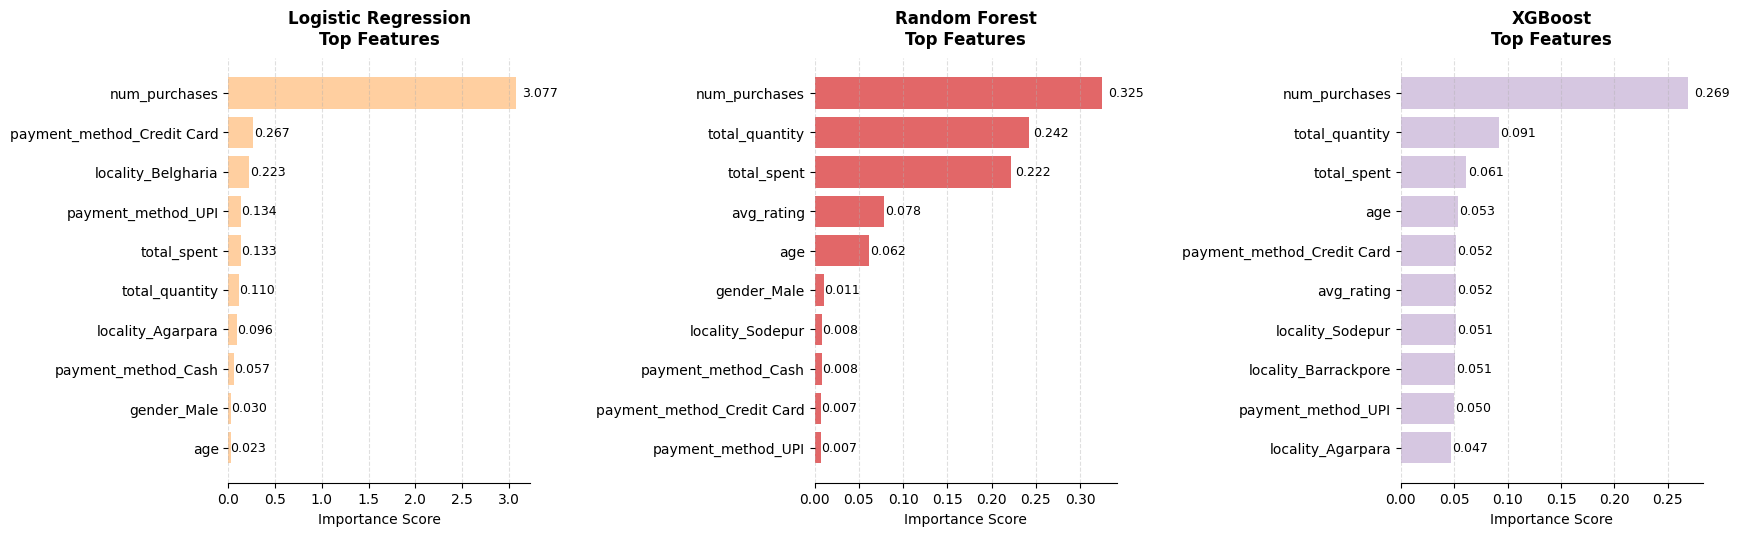


Consensus Features Sorted by Importance (Descending)
+----------------------------+----------------------+--------+----------------------+
| Feature                    |    Avg Importance    | Models |    Max Importance    |
+----------------------------+----------------------+--------+----------------------+
| num_purchases              |  1.2235762786294047  |   3    |  3.076558639024306   |
| total_quantity             | 0.14811012896292086  |   3    | 0.24242825342664148  |
| total_spent                | 0.13865917761855648  |   3    | 0.22161036487325458  |
| payment_method_Credit Card | 0.10871652484656193  |   3    |  0.2668705337326237  |
| payment_method_UPI         | 0.06359771177126738  |   3    | 0.13427845827959517  |
| locality_Agarpara          | 0.049728096435259224 |   3    |  0.0956539580391043  |
| avg_rating                 | 0.04635001239290317  |   3    | 0.07789181469853362  |
| age                        | 0.04580878347217603  |   3    | 0.06171973921643408  |


In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot top 10 features from each model horizontally
plt.figure(figsize=(18, 6))  # Wider figure for side-by-side plots

for i, (model_name, importance_df) in enumerate(importance_results.items(), 1):
    plt.subplot(1, 3, i)

    # Get top 10 features and sort for clean display
    top_10 = importance_df.head(10).sort_values('Importance', ascending=True)

    # Create horizontal bar plot
    bars = plt.barh(top_10['Feature'], top_10['Importance'],
                   color=plt.cm.tab20(i*3), alpha=0.7)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width*1.02, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}',
                va='center', ha='left', fontsize=9)

    plt.title(f'{model_name}\nTop Features', fontweight='bold', pad=10)
    plt.xlabel('Importance Score')
    plt.grid(axis='x', linestyle='--', alpha=0.4)

    # Remove spines for cleaner look
    for spine in ['top', 'right', 'left']:
        plt.gca().spines[spine].set_visible(False)

plt.tight_layout(pad=3.0)  # Add padding between subplots
plt.show()

# Find consensus features (appearing in ≥2 models' top 10)
top_features = {
    name: set(importance_df.head(10)['Feature'])
    for name, importance_df in importance_results.items()
}

# Calculate consensus features
consensus_features = set()
model_names = list(top_features.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        consensus_features.update(top_features[model_names[i]] & top_features[model_names[j]])

# Calculate and sort consensus features
consensus_data = []
for feature in consensus_features:
    model_count = 0
    total_importance = 0
    for model_name, importance_df in importance_results.items():
        if feature in importance_df['Feature'].values:
            model_count += 1
            total_importance += importance_df.loc[importance_df['Feature'] == feature, 'Importance'].values[0]
    avg_importance = total_importance / model_count
    consensus_data.append({
        'Feature': feature,
        'Avg Importance': avg_importance,
        'Models': model_count,
        'Max Importance': max(imp_df.loc[imp_df['Feature'] == feature, 'Importance'].values[0]
                          for imp_df in importance_results.values()
                          if feature in imp_df['Feature'].values)
    })

# Sort by average importance (descending)
consensus_df = pd.DataFrame(consensus_data).sort_values('Avg Importance', ascending=False)

# Format the table
table = tabulate(
    consensus_df,
    headers=['Feature', 'Avg Importance', 'Models', 'Max Importance'],
    tablefmt='pretty',
    floatfmt=".4f",
    showindex=False,
    colalign=('left', 'center', 'center', 'center')
)

# Print results
print("\n" + "="*70)
print("Consensus Features Sorted by Importance (Descending)")
print("="*70)
print(table)
print("\nKey:")
print("- Avg Importance: Mean importance score across all models")
print("- Models: Number of models where feature appears in top 10")
print("- Max Importance: Highest importance score from any model")

In [ ]:
# Define scoring metrics (focus on churn class)
def evaluate_model(y_true, y_pred, y_probs=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_1': precision_score(y_true, y_pred, pos_label=1),
        'recall_1': recall_score(y_true, y_pred, pos_label=1),
        'f1_1': f1_score(y_true, y_pred, pos_label=1),
        'average_precision': average_precision_score(y_true, y_probs) if y_probs is not None else None,
    }
    return metrics

# Evaluate all models
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    results[name] = evaluate_model(y_test, y_pred, y_probs)

# Convert to DataFrame and rank
results_df = pd.DataFrame(results).T
results_df['rank'] = results_df['average_precision'].rank(ascending=False).astype(int)
results_df = results_df.sort_values('rank')

# Print ranked results
print("="*60)
print("Model Performance Ranking (Higher Average Precision = Better)")
print("="*60)
print(results_df[['average_precision', 'f1_1', 'recall_1', 'precision_1', 'accuracy', 'rank']]
      .sort_values('rank')
      .to_markdown(floatfmt=".3f", tablefmt="grid"))

# Print detailed reports
for name in results_df.index:
    print(f"\n=== {name} ===")
    print(classification_report(y_test, models[name].predict(X_test)))

Model Performance Ranking (Higher Average Precision = Better)
+---------------------+---------------------+--------+------------+---------------+------------+--------+
|                     |   average_precision |   f1_1 |   recall_1 |   precision_1 |   accuracy |   rank |
+=====================+=====================+========+============+===============+============+========+
| Logistic Regression |               0.401 |  0.282 |      0.863 |         0.168 |      0.758 |  1.000 |
+---------------------+---------------------+--------+------------+---------------+------------+--------+
| XGBoost             |               0.305 |  0.360 |      0.351 |         0.369 |      0.931 |  2.000 |
+---------------------+---------------------+--------+------------+---------------+------------+--------+
| Random Forest       |               0.294 |  0.340 |      0.610 |         0.236 |      0.870 |  3.000 |
+---------------------+---------------------+--------+------------+---------------+-------

In [ ]:
# Rank by F1-score for churn (instead of AP)
results_df['rank_f1'] = results_df['f1_1'].rank(ascending=False).astype(int)
results_df = results_df.sort_values('rank_f1')

print("="*60)
print("Model Ranking by F1-Score for Churn (Higher = Better)")
print("="*60)
print(results_df[['f1_1', 'precision_1', 'recall_1', 'accuracy', 'rank_f1']]
      .sort_values('rank_f1')
      .to_markdown(floatfmt=".3f", tablefmt="grid"))

Model Ranking by F1-Score for Churn (Higher = Better)
+---------------------+--------+---------------+------------+------------+-----------+
|                     |   f1_1 |   precision_1 |   recall_1 |   accuracy |   rank_f1 |
+=====================+========+===============+============+============+===========+
| XGBoost             |  0.360 |         0.369 |      0.351 |      0.931 |     1.000 |
+---------------------+--------+---------------+------------+------------+-----------+
| Random Forest       |  0.340 |         0.236 |      0.610 |      0.870 |     2.000 |
+---------------------+--------+---------------+------------+------------+-----------+
| Logistic Regression |  0.282 |         0.168 |      0.863 |      0.758 |     3.000 |
+---------------------+--------+---------------+------------+------------+-----------+
